# Kaggle Fake News classification - LSTMs

Data description-

- id: unique id for a news article
- title: the title of a news article
- author: author of the news article
- text: the text of the article; could be incomplete
- label: a label that marks the article as potentially unreliable
     - unreliable
     - 0: reliable


For this code example, __only 'title' attribute is used__. Training on 'text' may take
longer to train.

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [83]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import tensorflow
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow as tf

In [4]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [5]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')
# print(f"GPU: {gpu_devices}")

if gpu_devices:
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: NVIDIA GeForce RTX 3080


2022-05-13 19:32:05.914335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 19:32:05.946223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 19:32:05.946380: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 19:32:05.947108: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [6]:
# Read in CSV file as pd DataFrame-
data = pd.read_csv("train.csv")

In [7]:
# Get shape/dimension-
data.shape

(20800, 5)

In [8]:
# Get columns/attribute names-
data.columns.tolist()

['id', 'title', 'author', 'text', 'label']

In [9]:
# Check data types for all attributes-
data.dtypes

id         int64
title     object
author    object
text      object
label      int64
dtype: object

In [10]:
# Get target attribute distribution-
data['label'].value_counts()

# Remeber that-
# 1: unreliable
# 0: reliable

1    10413
0    10387
Name: label, dtype: int64

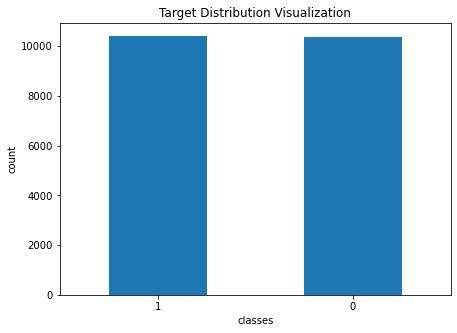

In [11]:
# Visualize data distribution-
plt.figure(figsize = (7, 5))
data['label'].value_counts().plot(kind = 'bar')
plt.xlabel("classes")
plt.ylabel("count")
plt.xticks(rotation = 0)
plt.title("Target Distribution Visualization")
plt.show()

In [12]:
# Check for total number of missing values-
if data.isna().values.any():
    print(f"Total number of missing values = {data.isnull().sum().sum()}")

Total number of missing values = 2554


In [13]:
# Check for missing values in all of the attributes-
for attr in data.columns.tolist():
    if data[attr].isna().values.any():
        print(f"{attr} has {data[attr].isna().sum()} NAs")

title has 558 NAs
author has 1957 NAs
text has 39 NAs


In [14]:
# Dataset shape before deleting NAs-
data.shape

(20800, 5)

In [15]:
# Delete all rows having any missing value in them-
data = data.dropna(axis = 0, how = 'any')

In [16]:
# Check dimension of data after dropping missing values-
data.shape

(18285, 5)

In [17]:
# Sanity check-
data.isna().values.any()

False

In [18]:
# Extract features (X) and label (y)-
X = data.drop(['id', 'label'], axis = 1)
y = data['label']

In [19]:
X.shape, y.shape

((18285, 3), (18285,))

In [20]:
# Sanity check-
X.head()

,title,author,text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


In [21]:
y[:5]

0    1
1    0
2    1
3    1
4    1
Name: label, dtype: int64

In [22]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/arjun/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/arjun/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Whenever we are providing input to 'Embedding' layer, we have to make sure that we keep our input size/length fixed. And for that, we need to pad either in front or back and we need 'pad_sequence' for that, so that the sentences become equal in length.

'one_hot' is used to convert the sentences into one-hot representation, given a vocabulary size.

Since this is a classification problem, the final layer should have one output layer which can output the probability needed for binary classification.

In [23]:
# Define the vocabulary/dictionary size.
# Our sentences comprises of all these words and nothing else.
vocab_size = 10000
# NOTE: changing this to 5000 may lead to a slight difference in the accuracy

In [24]:
messages = X.copy()

In [25]:
messages.shape

(18285, 3)

In [26]:
# Reset indices since we dropped the missing values-
messages.reset_index(inplace = True)

## Use ```title``` attribute to perform _sentiment classification_.

### Text Pre-processing:

1. Remove non-alpha numeric characters from raw text.
1. Convert all text to lower-case.
1. Tokenize words using ```split()``` (other tokenizers can also be experimented with).
1. Use stemmer/lemmatizer
1. Join _cleaned_ corpus back as a string.

In [27]:
from nltk.tokenize import RegexpTokenizer

In [28]:
# Create an instance of RegexpTokenizer for alphanumeric tokens
tokeniser = RegexpTokenizer(r'\w+')

In [29]:
title_str = messages['title'].astype(str)

In [30]:
# Tokenize 'title' attribute-
title_tokens = messages['title'].astype(str).apply(tokeniser.tokenize)

In [31]:
def remove_stopwords(text):
    '''
    Remove stop-words from input: pd.Series 'text'
    as input.
    '''
    return [word for word in text if not word in stopwords.words('english')]


In [32]:
# Remove stop-words-
title_cleaned = title_tokens.apply(remove_stopwords)

In [33]:
# Sanity check-
title_cleaned.head()

0    [House, Dem, Aide, We, Didn, Even, See, Comey,...
1    [FLYNN, Hillary, Clinton, Big, Woman, Campus, ...
2                 [Why, Truth, Might, Get, You, Fired]
3    [15, Civilians, Killed, In, Single, US, Airstr...
4    [Iranian, woman, jailed, fictional, unpublishe...
Name: title, dtype: object

In [34]:
# Initialize a WordNetLemmatizer-
lemmatiser = WordNetLemmatizer()

In [35]:
def lemmatize_text(text):
    '''
    Lemmatize input: pd.Series 'text' as
    input.
    '''
    # return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    return [lemmatiser.lemmatize(w.lower(), pos = 'v') for w in text]


In [39]:
# nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/arjun/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [40]:
# Lemmatize tokenised 'title'-
title_lemmatized = title_cleaned.apply(lemmatize_text)

In [41]:
# Sanity check-
title_lemmatized.head()

0    [house, dem, aide, we, didn, even, see, comey,...
1    [flynn, hillary, clinton, big, woman, campus, ...
2                  [why, truth, might, get, you, fire]
3    [15, civilians, kill, in, single, us, airstrik...
4    [iranian, woman, jail, fictional, unpublished,...
Name: title, dtype: object

In [42]:
del title_cleaned, title_tokens

In [43]:
# Convert to list-
title_lemmatized_l = title_lemmatized.to_list()

In [44]:
len(title_lemmatized_l)

18285

In [45]:
# Sanity check-
title_lemmatized_l[5]

['jackie',
 'mason',
 'hollywood',
 'would',
 'love',
 'trump',
 'he',
 'bomb',
 'north',
 'korea',
 'lack',
 'trans',
 'bathrooms',
 'exclusive',
 'video',
 'breitbart']

In [46]:
# Python3 list to contain pre-processed &
# cleaned text for 'title' attribute-
title_final = []

In [47]:
for t in title_lemmatized_l:
    title_final.append(' '.join(t))

In [48]:
# Sanity check-
len(title_final)

18285

In [49]:
# Sanity check-
title_final[:2]

['house dem aide we didn even see comey letter until jason chaffetz tweet it',
 'flynn hillary clinton big woman campus breitbart']

In [50]:
print(f"Length of cleaned corpus = {len(title_final)}")

Length of cleaned corpus = 18285


In [51]:
del title_lemmatized, title_lemmatized_l

In [43]:
"""
# Initialize a Porter Stemmer object-
ps = PorterStemmer()

# Python3 list to contain processed text-
corpus = []

for i in range(len(messages)):
    # print(i)

    # regular expression substitution for anything which is not alphabetical
    # with a blank space-
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])

    # convert the remaining text to lower case-
    review = review.lower()

    # Split the remaining text according to blank space into a list-
    review = review.split()

    # If a word is not a stop word, do the stemming and store the list of
    # words in 'review'-
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)

    corpus.append(review)


print(f"Length of cleaned corpus = {len(corpus)}")
# Length of cleaned corpus = 18285

"""

### One-hot representation for 'title' attribute-

We need to convert the processed text or 'corpus' into a one-hot representation. In one-hot representation, I require the index of the word based on the vocabulary size.

In [52]:
# Get one-hot vectors-
onehot_messages_representation = [one_hot(words, vocab_size) for words in title_final]

In [53]:
type(onehot_messages_representation), len(onehot_messages_representation)

(list, 18285)

In [54]:
# Sanity check-
onehot_messages_representation[0:3]

# NOTE: all of the one hot representation sentence lengths are different.
# Before passing them to the 'Embedding' layer, I have to make them to be of
# fixed lenght/size.

[[1121,
  3197,
  6865,
  1474,
  5863,
  7371,
  2328,
  7920,
  3819,
  9257,
  630,
  626,
  5484,
  2686],
 [1549, 586, 7810, 5842, 5393, 4902, 5475],
 [9494, 339, 9891, 3234, 6102, 3037]]

In [55]:
# Further sanity check-
title_final[0]

'house dem aide we didn even see comey letter until jason chaffetz tweet it'

In [56]:
onehot_messages_representation[0]

[1121,
 3197,
 6865,
 1474,
 5863,
 7371,
 2328,
 7920,
 3819,
 9257,
 630,
 626,
 5484,
 2686]

In [57]:
# Find maximum sentence length using train data-
max_sent_len = 0
pos = 0
i = 0

for s in title_final:
    if len(s) > max_sent_len:
        max_sent_len = len(s)
        pos = i
    i += 1

In [58]:
print(f"Maximum sentence length = {max_sent_len} which occurs in {pos} index")

Maximum sentence length = 350 which occurs in 14259 index


In [59]:
# Sanity check-
title_final[pos]

'scott bennett whistleblower u s army terrorist threat finance analyst under dov zakheim a gross perversion justice ubs whistleblower brad birkenfeld work with cia edward snowden terrorist finance bank ubs hsbc be represent covington burl employer eric holder lanny breuer michael chertoff roger zakheim demand accountability from your representatives'

#### Pad documents/sequences

The neural network expects all sentences to have the same size. To achieve this, pad the input sentences. For all of the given sentences, make it a 20-word sentence using ```pad_senquences()```.

In [60]:
# Use 'pad_sequences()' to make the text to be of same size-

# Maximum sentence length AFTER padding-
sentence_len = max_sent_len

In [61]:
# Add zeroes before due to 'pre' padding-
embedded_sent = pad_sequences(
        onehot_messages_representation, padding = 'pre',
        maxlen = sentence_len
        )

In [62]:
type(embedded_sent), embedded_sent.shape

(numpy.ndarray, (18285, 350))

In [63]:
# Sanity check-
embedded_sent[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [64]:
embedded_sent[0].shape

(350,)

In [65]:
'''
The 'Embedding' layer takes a fixed-size input and converts it into some specified
number of (dense) embedding features/vectors.
'''
# Embedding vector dimensions-
embedding_feature = 100

In [66]:
# Sanity check-
print(f"Vocabulary size = {vocab_size}, embedding dimensionality = "
      f"{embedding_feature} & padded sentence input length = {sentence_len}"
     )

Vocabulary size = 10000, embedding dimensionality = 100 & padded sentence input length = 350


### Create different _Seq2Seq_ models-

In [67]:
def lstm_model():
    # Function to define LSTM model
    model = Sequential()

    # Add an 'Embedding' layer-
    model.add(
        Embedding(
        input_dim = vocab_size, output_dim = embedding_feature,
        embeddings_initializer = 'uniform',
        embeddings_regularizer = None,
        input_length = sentence_len
        )
    )

    # Add drop out layer-
    model.add(Dropout(0.3))

    # One LSTM layer having 100 neurons-
    model.add(
        LSTM(
            units = 100, activation = tf.keras.activations.tanh,
            return_sequences = False
        )
    )

    # Add drop out layer-
    model.add(Dropout(rate = 0.3))

    # Add a dense layer due to classification (binary classification)-
    model.add(Dense(units = 1, activation = tf.keras.activations.sigmoid))
    
    # Compile defined LSTM model-
    model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
        metrics = ['accuracy']
    )

    return model


In [85]:
def stacked_lstm_model():
    # Function to define stacked LSTM model
    model = Sequential()

    # Add an 'Embedding' layer-
    model.add(
        Embedding(
        input_dim = vocab_size, output_dim = embedding_feature,
        embeddings_initializer = 'uniform',
        embeddings_regularizer = None,
        input_length = sentence_len
        )
    )

    # Add drop out layer-
    model.add(Dropout(0.3))

    # One LSTM layer having 100 neurons-
    model.add(
        LSTM(
            units = 100, activation = tf.keras.activations.tanh,
            return_sequences = True
        )
    )

    # Add drop out layer-
    model.add(Dropout(rate = 0.3))
    
    model.add(
        LSTM(
            units = 64, activation = tf.keras.activations.tanh,
            return_sequences = False
        )
    )
    
    model.add(Dropout(rate = 0.3))

    # Add a dense layer due to classification (binary classification)-
    model.add(Dense(units = 1, activation = tf.keras.activations.sigmoid))
    
    # Compile defined LSTM model-
    model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
        metrics = ['accuracy']
    )

    return model


In [90]:
def bidirectional_lstm_model():
    # Function to define Bi-directional LSTM model
    model = Sequential()

    # Add an 'Embedding' layer-
    model.add(
        Embedding(
        input_dim = vocab_size, output_dim = embedding_feature,
        embeddings_initializer = 'uniform',
        embeddings_regularizer = None,
        input_length = sentence_len
        )
    )

    # Add drop out layer-
    model.add(Dropout(0.3))

    # One Bi-directional LSTM layer having 100 neurons-
    model.add(
        Bidirectional(
            LSTM(
                units = 100, activation = tf.keras.activations.tanh,
                return_sequences = False
            )
        )
    )

    # Add drop out layer-
    model.add(Dropout(rate = 0.3))

    # Add a dense layer due to classification (binary classification)-
    model.add(Dense(units = 1, activation = tf.keras.activations.sigmoid))
    
    # Compile defined LSTM model-
    model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
        metrics = ['accuracy']
    )

    return model


In [91]:
def bidirectional_stacked_lstm_model():
    # Function to define Bi-directional stacked LSTM model
    model = Sequential()

    # Add an 'Embedding' layer-
    model.add(
        Embedding(
        input_dim = vocab_size, output_dim = embedding_feature,
        embeddings_initializer = 'uniform',
        embeddings_regularizer = None,
        input_length = sentence_len
        )
    )

    # Add drop out layer-
    model.add(Dropout(0.3))

    # One Bi-directional LSTM layer having 100 neurons-
    model.add(
        Bidirectional(
            LSTM(
                units = 100, activation = tf.keras.activations.tanh,
                return_sequences = True
            )
        )
    )

    # Add drop out layer-
    model.add(Dropout(rate = 0.3))
    
    # One Bi-directional LSTM layer having 100 neurons-
    model.add(
        Bidirectional(
            LSTM(
                units = 64, activation = tf.keras.activations.tanh,
                return_sequences = False
            )
        )
    )

    # Add drop out layer-
    model.add(Dropout(rate = 0.3))

    # Add a dense layer due to classification (binary classification)-
    model.add(Dense(units = 1, activation = tf.keras.activations.sigmoid))
    
    # Compile defined LSTM model-
    model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
        metrics = ['accuracy']
    )

    return model


In [68]:
# Initialize single LSTM model-
model = lstm_model()

2022-05-13 19:35:36.638142: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-13 19:35:36.639217: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 19:35:36.639407: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 19:35:36.639550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [92]:
# Initialize stacked LSTM model-
model_stacked = stacked_lstm_model()

In [93]:
# Initialize Bi-directional LSTM model-
model_bi = bidirectional_lstm_model()

In [94]:
# Initialize Bi-directional stacked LSTM model-
model_bi_stacked = bidirectional_stacked_lstm_model()

In [69]:
# Get model's summary-
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 100)          1000000   
                                                                 
 dropout (Dropout)           (None, 350, 100)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________


In [95]:
# Get summary for stacked LSTM model-
model_stacked.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 350, 100)          1000000   
                                                                 
 dropout_8 (Dropout)         (None, 350, 100)          0         
                                                                 
 lstm_5 (LSTM)               (None, 350, 100)          80400     
                                                                 
 dropout_9 (Dropout)         (None, 350, 100)          0         
                                                                 
 lstm_6 (LSTM)               (None, 64)                42240     
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [96]:
# Get summary for bi-directional LSTM model-
model_bi.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 350, 100)          1000000   
                                                                 
 dropout_11 (Dropout)        (None, 350, 100)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 201       
                                                                 
Total params: 1,161,001
Trainable params: 1,161,001
Non-trainable params: 0
____________________________________________

In [97]:
# Get summary for bi-directional stacked LSTM model-
model_bi_stacked.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 350, 100)          1000000   
                                                                 
 dropout_13 (Dropout)        (None, 350, 100)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 350, 200)         160800    
 nal)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 350, 200)          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              135680    
 nal)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 128)              

In [70]:
# Get layer-wise shape/dimensions-
for layer in model.weights:
    print(layer.shape)

(10000, 100)
(100, 400)
(100, 400)
(400,)
(100, 1)
(1,)


In [71]:
len(embedded_sent), y.shape

(18285, (18285,))

In [72]:
X_final = np.array(embedded_sent).astype('float')
y_final = np.array(y)

In [73]:
X_final.shape, y_final.shape

((18285, 350), (18285,))

In [74]:
# Split into training and testing sets-
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final,
    test_size = 0.3, stratify = y_final
)

In [75]:
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (12799, 350), y_train.shape: (12799,)
X_test.shape: (5486, 350), y_test.shape: (5486,)


In [76]:
# Train defined model for single LSTM-
train_history = model.fit(
    x = X_train, y = y_train,
    epochs = 10, batch_size = 64,
    validation_data = (X_test, y_test)
)

Epoch 1/10


2022-05-13 19:36:09.729699: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


  5/200 [..............................] - ETA: 2s - loss: 0.5934 - accuracy: 0.6250  

2022-05-13 19:36:10.089239: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


200/200 [==============================] - 6s 18ms/step - loss: 0.2122 - accuracy: 0.9090 - val_loss: 0.1641 - val_accuracy: 0.9313
Epoch 2/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0863 - accuracy: 0.9684 - val_loss: 0.1901 - val_accuracy: 0.9300
Epoch 3/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0365 - accuracy: 0.9866 - val_loss: 0.2916 - val_accuracy: 0.9295
Epoch 4/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0179 - accuracy: 0.9947 - val_loss: 0.3263 - val_accuracy: 0.9273
Epoch 5/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0084 - accuracy: 0.9974 - val_loss: 0.3800 - val_accuracy: 0.9273
Epoch 6/10
200/200 [==============================] - 3s 18ms/step - loss: 0.0072 - accuracy: 0.9980 - val_loss: 0.4384 - val_accuracy: 0.9291
Epoch 7/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0056 - accuracy: 0.9982 - val_loss: 0.4571 - val_accuracy: 0.9242
Epoch 8/10

In [98]:
# Train defined model for stacked LSTM-
train_history_stacked_lstm = model_stacked.fit(
    x = X_train, y = y_train,
    epochs = 10, batch_size = 64,
    validation_data = (X_test, y_test)
)

Epoch 1/10
200/200 [==============================] - 7s 28ms/step - loss: 0.2346 - accuracy: 0.8996 - val_loss: 0.1652 - val_accuracy: 0.9269
Epoch 2/10
200/200 [==============================] - 5s 26ms/step - loss: 0.0994 - accuracy: 0.9635 - val_loss: 0.1795 - val_accuracy: 0.9349
Epoch 3/10
200/200 [==============================] - 5s 26ms/step - loss: 0.0487 - accuracy: 0.9848 - val_loss: 0.2385 - val_accuracy: 0.9262
Epoch 4/10
200/200 [==============================] - 5s 26ms/step - loss: 0.0209 - accuracy: 0.9925 - val_loss: 0.3779 - val_accuracy: 0.9289
Epoch 5/10
200/200 [==============================] - 5s 26ms/step - loss: 0.0149 - accuracy: 0.9957 - val_loss: 0.3475 - val_accuracy: 0.9293
Epoch 6/10
200/200 [==============================] - 5s 27ms/step - loss: 0.0127 - accuracy: 0.9962 - val_loss: 0.3628 - val_accuracy: 0.9231
Epoch 7/10
200/200 [==============================] - 5s 26ms/step - loss: 0.0066 - accuracy: 0.9984 - val_loss: 0.4301 - val_accuracy: 0.9298

In [99]:
# Train defined model for bi-directional LSTM-
train_history_bi_lstm = model_bi.fit(
    x = X_train, y = y_train,
    epochs = 10, batch_size = 64,
    validation_data = (X_test, y_test)
)

Epoch 1/10
200/200 [==============================] - 8s 33ms/step - loss: 0.2418 - accuracy: 0.8947 - val_loss: 0.1639 - val_accuracy: 0.9329
Epoch 2/10
200/200 [==============================] - 6s 31ms/step - loss: 0.0888 - accuracy: 0.9681 - val_loss: 0.1784 - val_accuracy: 0.9329
Epoch 3/10
200/200 [==============================] - 6s 31ms/step - loss: 0.0306 - accuracy: 0.9881 - val_loss: 0.3223 - val_accuracy: 0.9271
Epoch 4/10
200/200 [==============================] - 6s 31ms/step - loss: 0.0177 - accuracy: 0.9936 - val_loss: 0.3120 - val_accuracy: 0.9192
Epoch 5/10
200/200 [==============================] - 6s 31ms/step - loss: 0.0079 - accuracy: 0.9975 - val_loss: 0.4038 - val_accuracy: 0.9267
Epoch 6/10
200/200 [==============================] - 6s 31ms/step - loss: 0.0089 - accuracy: 0.9966 - val_loss: 0.3726 - val_accuracy: 0.9231
Epoch 7/10
200/200 [==============================] - 6s 32ms/step - loss: 0.0113 - accuracy: 0.9965 - val_loss: 0.4115 - val_accuracy: 0.9220

In [100]:
# Train defined model for bi-directional stacked LSTM-
train_history_bi_stacked_lstm = model_bi_stacked.fit(
    x = X_train, y = y_train,
    epochs = 10, batch_size = 64,
    validation_data = (X_test, y_test)
)

Epoch 1/10
200/200 [==============================] - 13s 54ms/step - loss: 0.2322 - accuracy: 0.9016 - val_loss: 0.1679 - val_accuracy: 0.9282
Epoch 2/10
200/200 [==============================] - 10s 49ms/step - loss: 0.1011 - accuracy: 0.9604 - val_loss: 0.1923 - val_accuracy: 0.9293
Epoch 3/10
200/200 [==============================] - 10s 49ms/step - loss: 0.0462 - accuracy: 0.9837 - val_loss: 0.2666 - val_accuracy: 0.9242
Epoch 4/10
200/200 [==============================] - 10s 49ms/step - loss: 0.0272 - accuracy: 0.9905 - val_loss: 0.3088 - val_accuracy: 0.9182
Epoch 5/10
200/200 [==============================] - 10s 49ms/step - loss: 0.0202 - accuracy: 0.9926 - val_loss: 0.4061 - val_accuracy: 0.9225
Epoch 6/10
200/200 [==============================] - 10s 49ms/step - loss: 0.0148 - accuracy: 0.9955 - val_loss: 0.3802 - val_accuracy: 0.9203
Epoch 7/10
200/200 [==============================] - 10s 49ms/step - loss: 0.0101 - accuracy: 0.9969 - val_loss: 0.4167 - val_accuracy:

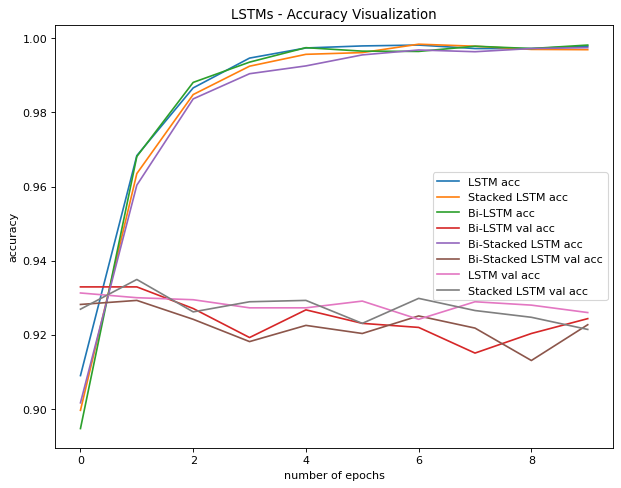

In [103]:
# Visualize accuracy-
plt.figure(figsize = (9, 7), dpi = 80, facecolor = 'w', edgecolor = 'k')

plt.plot(train_history.history['accuracy'], label = 'LSTM acc')
plt.plot(train_history_stacked_lstm.history['accuracy'], label = 'Stacked LSTM acc')
plt.plot(train_history_bi_lstm.history['accuracy'], label = 'Bi-LSTM acc')
plt.plot(train_history_bi_lstm.history['val_accuracy'], label = 'Bi-LSTM val acc')
plt.plot(train_history_bi_stacked_lstm.history['accuracy'], label = 'Bi-Stacked LSTM acc')
plt.plot(train_history_bi_stacked_lstm.history['val_accuracy'], label = 'Bi-Stacked LSTM val acc')
plt.plot(train_history.history['val_accuracy'], label = 'LSTM val acc')
plt.plot(train_history_stacked_lstm.history['val_accuracy'], label = 'Stacked LSTM val acc')

plt.title("LSTMs - Accuracy Visualization")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend(loc = "best")

plt.show()

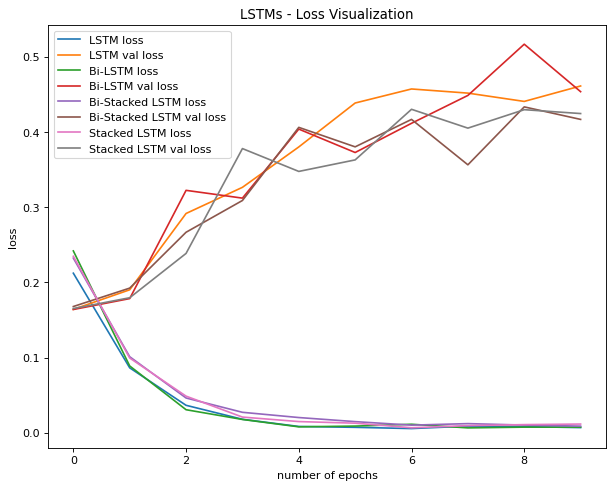

In [104]:
# Visualize loss-
plt.figure(figsize = (9, 7), dpi = 80, facecolor = 'w', edgecolor = 'k')

plt.plot(train_history.history['loss'], label = 'LSTM loss')
plt.plot(train_history.history['val_loss'], label = 'LSTM val loss')
plt.plot(train_history_bi_lstm.history['loss'], label = 'Bi-LSTM loss')
plt.plot(train_history_bi_lstm.history['val_loss'], label = 'Bi-LSTM val loss')
plt.plot(train_history_bi_stacked_lstm.history['loss'], label = 'Bi-Stacked LSTM loss')
plt.plot(train_history_bi_stacked_lstm.history['val_loss'], label = 'Bi-Stacked LSTM val loss')
plt.plot(train_history_stacked_lstm.history['loss'], label = 'Stacked LSTM loss')
plt.plot(train_history_stacked_lstm.history['val_loss'], label = 'Stacked LSTM val loss')

plt.title("LSTMs - Loss Visualization")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.legend(loc = "best")

plt.show()

In [105]:
# Get trained model metrics on validation data-
y_pred = model.predict(X_test)
y_pred_stacked = model_stacked.predict(X_test)
y_pred_bi = model_bi.predict(X_test)
y_pred_bi_stacked = model_bi_stacked.predict(X_test)

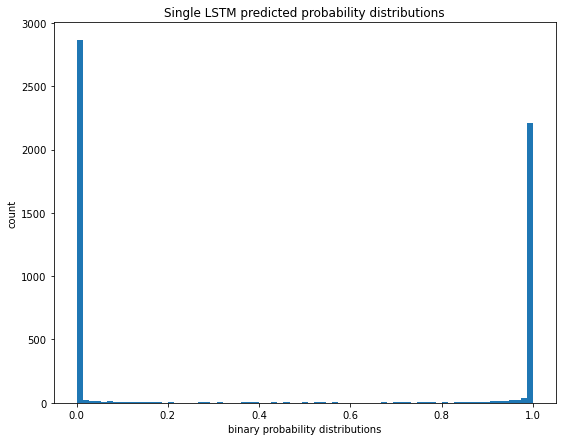

In [111]:
plt.figure(figsize = (9, 7))
plt.hist(y_pred, bins = int(np.ceil(np.sqrt(y_pred.size))))
plt.xlabel("binary probability distributions")
plt.ylabel("count")
plt.title("Single LSTM predicted probability distributions")
plt.show()

In [ ]:
# Get accuracy for different models-
acc = accuracy_score(y_true = y_test, y_pred = y_pred)
acc_stacked = accuracy_score(y_true = y_test, y_pred = y_pred_stacked)
acc_bi = accuracy_score(y_true = y_test, y_pred = y_pred_bi)
acc_bi_stacked = accuracy_score(y_true = y_test, y_pred = y_pred_bi_stacked)

In [112]:
# Compute trained model's validation accuracy and loss-
val_loss, val_acc = model.evaluate(X_test, y_test, verbose = 1)

172/172 [==============================] - 1s 5ms/step - loss: 0.4611 - accuracy: 0.9260


In [113]:
val_loss_stacked, val_acc_stacked = model_stacked.evaluate(X_test, y_test, verbose = 1)

172/172 [==============================] - 1s 8ms/step - loss: 0.4244 - accuracy: 0.9214


In [114]:
val_loss_bi, val_acc_bi = model_bi.evaluate(X_test, y_test, verbose = 1)

172/172 [==============================] - 1s 8ms/step - loss: 0.4535 - accuracy: 0.9244


In [115]:
val_loss_bi_stacked, val_acc_bi_stacked = model_bi_stacked.evaluate(X_test, y_test, verbose = 1)

172/172 [==============================] - 3s 15ms/step - loss: 0.4167 - accuracy: 0.9227


In [116]:
print(f"LSTM trained model's validation loss = {val_loss:.4f} & validation accuracy = {val_acc * 100:.2f}%")
print(f"Stacked LSTM trained model's validation loss = {val_loss_stacked:.4f} & validation accuracy = {val_acc_stacked * 100:.2f}%")
print(f"Bi-directional LSTM trained model's validation loss = {val_loss_bi:.4f} & validation accuracy = {val_acc_bi * 100:.2f}%")
print(f"Bi-directional Stacked LSTM trained model's validation loss = {val_loss_bi_stacked:.4f} & validation accuracy = {val_acc_bi_stacked * 100:.2f}%")

LSTM trained model's validation loss = 0.4611 & validation accuracy = 92.60%
Stacked LSTM trained model's validation loss = 0.4244 & validation accuracy = 92.14%
Bi-directional LSTM trained model's validation loss = 0.4535 & validation accuracy = 92.44%
Bi-directional Stacked LSTM trained model's validation loss = 0.4167 & validation accuracy = 92.27%


In [69]:
# Save trained (with dropouts) to HDD-
model.save("Trained_LSTM_model.h5", overwrite=True)